# OpenTripplanner (OTP)

- [opentripplanner.org/](https://www.opentripplanner.org/)

# Download Data for Vienna

- BBBike - [Vienna OpenStreetMap Extract](https://www.bbbike.org/Wien/)
- Open Data Austria - [Wiener Linien – Fahrplandaten GTFS Wien](https://www.data.gv.at/katalog/dataset/ab4a73b6-1c2d-42e1-b4d9-049e04889cf0)

In [1]:
%%bash
mkdir -p data
if [ ! -f "data/vienna.osm.pbf" ]; then
    echo "Downloading vienna.osm.pbf"
    wget https://download.bbbike.org/osm/bbbike/Wien/Wien.osm.pbf \
      -qO data/vienna.osm.pbf
fi

if [ ! -f "data/vienna.gtfs.zip" ]; then
    echo "Downloading vienna.gtfs.zip"
    wget http://www.wienerlinien.at/ogd_realtime/doku/ogd/gtfs/gtfs.zip \
      -qO data/vienna.gtfs.zip
fi

# Visualize and Filter GTFS

- [triply-at/gtfsutils](https://github.com/triply-at/gtfsutils)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely.geometry
import geopandas as gpd
import contextily as cx

import gtfsutils
import gtfsutils.routes
import gtfsutils.filter

In [3]:
%%time
df_dict = gtfsutils.load_gtfs("data/vienna.gtfs.zip")
df_dict.keys()

CPU times: user 5.32 s, sys: 521 ms, total: 5.84 s
Wall time: 5.85 s


dict_keys(['stops', 'stop_times', 'shapes', 'calendar', 'calendar_dates', 'trips', 'routes', 'agency'])

In [4]:
gdf_routes = gtfsutils.routes.load_routes_counts(df_dict)
gdf_routes.head(2)

,route_id,route_short_name,route_long_name,route_type,agency_id,agency_name,counts,geometry
0,11-WLB-j22-1,RT1,Baden - Traiskirchen - Guntramsdorf - Wiener N...,0,3,WLB,764,"LINESTRING (16.37064 48.20200, 16.36766 48.198..."
1,11-WLB-j22-2,RT1,Baden - Traiskirchen - Guntramsdorf - Wiener N...,0,3,WLB,176,"LINESTRING (16.37064 48.20200, 16.36766 48.198..."


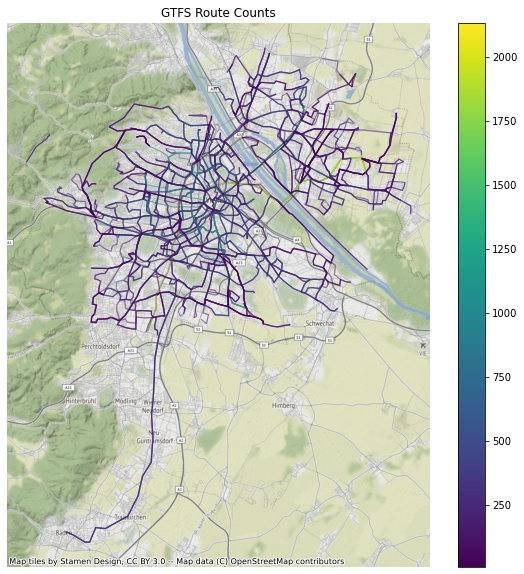

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf_plot = gdf_routes.to_crs(epsg=3857)
gdf_plot.plot(ax=ax, column='counts', cmap='viridis', linewidth=1.2, alpha=0.5, legend=True)

cx.add_basemap(ax, crs=gdf_plot.crs.to_string())
ax.set_title("GTFS Route Counts")
ax.axis('off');

In [6]:
df_dict['agency']

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone
0,3,WLB,https://www.wlb.at/,Europe/Vienna,DE,+43 (0) 1/ 90 444
1,4,Wiener Linien,https://www.wienerlinien.at/,Europe/Vienna,DE,+43 (0)1 7909 - 0


# Filter GTFS by Agency

In [7]:
%%time
gtfsutils.filter.filter_by_agency_ids(df_dict, [4])

CPU times: user 543 ms, sys: 83.1 ms, total: 626 ms
Wall time: 626 ms


In [9]:
%%time
gdf_routes = gtfsutils.routes.load_routes_counts(df_dict)

CPU times: user 1.46 s, sys: 3.56 ms, total: 1.46 s
Wall time: 1.47 s


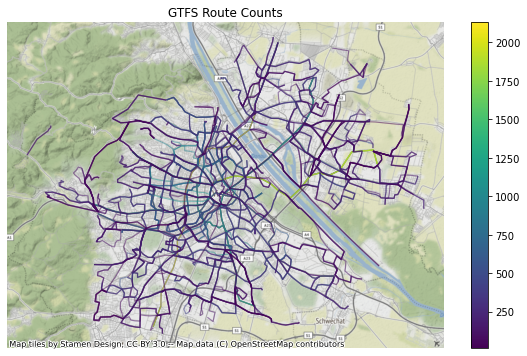

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

gdf_plot = gdf_routes.to_crs(epsg=3857)
gdf_plot.plot(ax=ax, column='counts', cmap='viridis', linewidth=1.2, alpha=0.5, legend=True)

cx.add_basemap(ax, crs=gdf_plot.crs.to_string())
ax.set_title("GTFS Route Counts")
ax.axis('off');

# Save Filtered GTFS

In [ ]:
gtfsutils.save_gtfs(df_dict, "data/vienna.gtfs.zip")

# Build and Run OTP with Docker

In [17]:
%%bash
docker-compose \
  -f docker/docker-compose.yml up \
  --build -d otp \
  > /dev/null

Creating network "docker_default" with the default driver
Building otp
Creating docker_otp_1 ... 
ting docker_otp_1 ... done

Show the container with:

In [18]:
!docker ps

CONTAINER ID   IMAGE        COMMAND                  CREATED         STATUS         PORTS                                       NAMES
b2462ddb7045   docker_otp   "/bin/sh -c 'java ${…"   7 seconds ago   Up 2 seconds   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp   docker_otp_1


Show container logs with:

In [22]:
%%bash
docker-compose \
  -f docker/docker-compose.yml logs otp \
  | tail -n 4

otp_1      | 18:24:28.792 INFO (NetworkListener.java:750) Started listener bound to [0.0.0.0:8080]
otp_1      | 18:24:28.800 INFO (NetworkListener.java:750) Started listener bound to [0.0.0.0:8081]
otp_1      | 18:24:28.802 INFO (HttpServer.java:300) [HttpServer] Started.
otp_1      | 18:24:28.802 INFO (GrizzlyServer.java:152) Grizzly server running.


To follow the log output add the `-f` argument:

```bash
docker-compose \
  -f docker/docker-compose.yml logs -f otp
```

You should be able to access OTP now by opening `localhost:8080` in your browser and run routing within Vienna.

Stop the container with:

In [15]:
%%bash
docker-compose -f docker/docker-compose.yml down

Stopping docker_otp_1 ... 
Removing docker_otp_1 ... mdone
Removing network docker_default


# OTP API

In [23]:
import requests
import datetime

from IPython.display import JSON

Show the version and build information of OpenTripPlanner with:

In [24]:
r = requests.get("http://localhost:8080/otp")
r.json()

{'serverVersion': {'version': '2.0.0',
  'major': 2,
  'minor': 0,
  'incremental': 0,
  'qualifier': '',
  'commit': 'a64576040edff06e84033f2e78991a5ba56b2f78',
  'branch': 'v2.0.0',
  'describe': 'v2.0.0',
  'commitTime': '2020-11-27T12:58:18+0000',
  'buildTime': '2020-11-27T13:02:08+0000',
  'dirty': False,
  'longVersionString': 'version: 2.0.0, commit: a64576040edff06e84033f2e78991a5ba56b2f78, branch: v2.0.0',
  'shortVersionString': 'OpenTripPlanner 2.0.0 a64576040edff06e84033f2e78991a5ba56b2f78',
  'uid': 2000000},
 'cpuName': 'Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz',
 'nCores': 4}

Get information about the default router with:

In [25]:
r = requests.get("http://localhost:8080/otp/routers/default")
JSON(r.json(), expanded=False)

<IPython.core.display.JSON object>

# Routing with OTP

Routing is done via the [PlannerResource](http://dev.opentripplanner.org/apidoc/2.0.0/resource_PlannerResource.html) endpoint. Here is an example route from Vienna Westbahnhof to the Vienna Giant Ferris Wheel:

In [26]:
base_url = "http://localhost:8080/otp/routers/default/plan"

# Vienna Westbahnhof
start_point = (48.195822, 16.338451)
# Vienna Giant Ferris Wheel
end_point = (48.2166, 16.3959)

# Departure at 01.04.2022 12:00
depart_time = datetime.datetime(2022, 4, 1, 12, 0)

r = requests.get(base_url, params={
    'fromPlace': ",".join(map(str, start_point)),
    'toPlace': ",".join(map(str, end_point)),
    'date': depart_time.strftime('%d-%m-%Y'),
    'time': depart_time.strftime('%H:%M'),
    'mode': 'WALK,TRANSIT',
    'maxWalkDistance': 1000
})

data = r.json()

In [27]:
JSON(data, expanded=False)

<IPython.core.display.JSON object>

Check the duration for the first itinerary:

In [47]:
itinerary = data['plan']['itineraries'][0]

print(f"Duration: {itinerary['duration']} seconds")

Duration: 1802 seconds


Each itinerary is split into legs which are paths of a single transit mode. Each leg consists of steps, which are the coordinates of the path. Here is how the first leg looks like:

In [29]:
df_steps = pd.DataFrame(itinerary['legs'][2]['steps'])
df_steps

,distance,relativeDirection,streetName,absoluteDirection,stayOn,area,bogusName,lon,lat,elevation
0,2.206,DEPART,Landstraßer Hauptstraße,SOUTHEAST,False,False,False,16.385576,48.205775,
1,26.004,RIGHT,Invalidenstraße,SOUTHWEST,False,False,False,16.385603,48.205767,
2,0.000,RIGHT,Mitte-Landstraße S+U,NORTHWEST,False,False,False,16.385447,48.205557,


# Create GeoPandas GeoDataFrame from Itinerary

OTP uses the [Encoded Polyline Algorithm Format](https://developers.google.com/maps/documentation/utilities/polylinealgorithm) to encode the geometry of each leg. To decode the polyline strings, install the [polyline](https://github.com/frederickjansen/polyline) with:

```bash
pip install polyline
```

In [39]:
import polyline

In [87]:
itinerary = data['plan']['itineraries'][0]

leg_geometries = []
for leg in itinerary['legs']:
    coordinates = polyline.decode(
        leg['legGeometry']['points'],
        geojson=True)
    if coordinates:
        leg_geometry = shapely.geometry.LineString(coordinates)
        leg_geometries.append(leg_geometry)

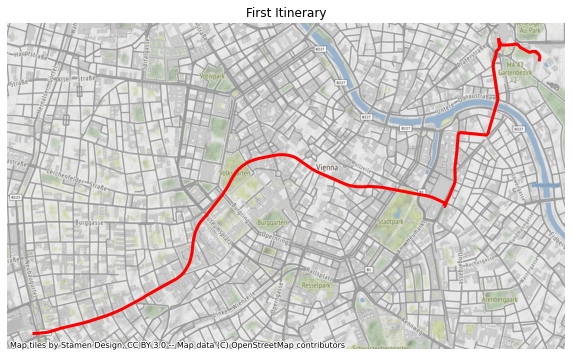

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))

gpd.GeoSeries(leg_geometries, crs='EPSG:4326').to_crs(epsg=3857).plot(
    ax=ax, color='r', linewidth=3)

cx.add_basemap(ax, crs=gdf_plot.crs.to_string())
ax.set_title("First Itinerary")
ax.axis('off');

# Show all Itineraries

In [89]:
gdf_list = []

for itinerary in data['plan']['itineraries']:
    leg_geometries = []
    for leg in itinerary['legs']:
        coordinates = polyline.decode(
            leg['legGeometry']['points'],
            geojson=True)
        if coordinates:
            leg_geometry = shapely.geometry.LineString(coordinates)
            leg_geometries.append(leg_geometry)
    
    gdf_list.append(
        gpd.GeoSeries(leg_geometries, crs='EPSG:4326'))

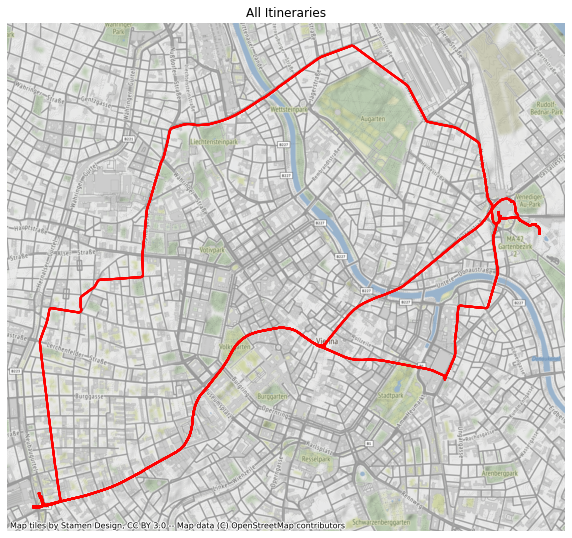

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))

for gdf in gdf_list:
    gdf.to_crs(epsg=3857).plot(
        ax=ax, color='r', linewidth=2)

cx.add_basemap(ax, crs=gdf_plot.crs.to_string())
ax.set_title("All Itineraries")
ax.axis('off');